# Optimisation in a transformed parameter space - using a model wrapper

This example shows you how to run an optimisation in a transformed parameter space by writing a wrapper around a [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.ForwardModel).
(For an introduction to PINTS optimisation, see: [Optimisation: first example](./first-example.ipynb).)

Pints provides a transformation interface through [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation).
We show how to use `pints.Transformation` for an [optimisation example](./transformed-parameters.ipynb) and for a [sampling example](../sampling/transformed-parameters.ipynb).
We strongly recommand using Pints' transformation interface as it handles all the subtle corrections such as Jacobian adjustment for PDFs, chain rule for calculating sensitivity, etc. that one can easily miss by writing his/her own transformation wrapper.

First we will create a toy model, in this case a [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

model = toy.LogisticModel()

The parameter vector for the toy logistic model is $\theta_\text{org} = [r, K]$, where $r$ is a growth rate and $K$ is called the carrying capacity.
Because these parameters have very different magnitudes, we will create a wrapper that instead uses the parameter vector $\theta = [r, \log(K)]$

In [2]:
class TransformedModel(pints.ForwardModel):
    def __init__(self, model):
        self._model = model
    
    def n_parameters(self):
        return self._model.n_parameters()
    
    def simulate(self, parameters, times):
        transformed_parameters = [parameters[0], np.exp(parameters[1])]
        return self._model.simulate(transformed_parameters,times)

transformed_model = TransformedModel(model)

Just like the untransformed model, we can use this transformed variant with several PINTS routines.

For example, we can fit it to a synthetic data set using CMA-ES:

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      3.44e+07   0:00.0
1     12     3.4e+07    0:00.0
2     18     3.34e+07   0:00.0
3     24     3.14e+07   0:00.0
20    126    643723.5   0:00.1
40    246    188157.2   0:00.1
60    366    101666.8   0:00.1
80    486    101437.4   0:00.2
100   606    101437.1   0:00.2
120   726    101437.1   0:00.3
140   846    101437.1   0:00.3
160   966    101437.1   0:00.4
180   1086   101437.1   0:00.4
200   1206   101437.1   0:00.5
220   1326   101437.1   0:00.5
240   1446   101437.1   0:00.6
260   1566   101437.1   0:00.6
280   1686   101437.1   0:00.6
300   1806   101437.1   0:00.7
320   1926   101437.1   0:00.7
340   2046   101437.1   0:00.8
342   2052   101437.1   0:00.8
Halting: No significant change for 200 iterations.
Score at true solution: 
101503.5654159602
Found solution:          True parameters:
 1.5014720623022

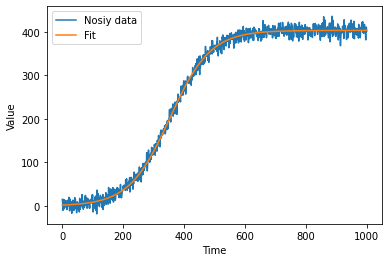

In [3]:
# Create some toy data
real_parameters = [0.015, 6]
times = np.linspace(0, 1000, 1000)
values = transformed_model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(transformed_model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, -6.0], [0.03, 20.0])

# Perform an optimisation with boundaries and hints
x0 = 0.01,5.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()